# Module 3

In [1]:
import matplotlib.pyplot as plt
import imageio as img
import numpy as np
import scipy as sp
import skimage as ski #for different image analysis algorithms
import skimage.filters
import image_analysis as anl
import seaborn as sns; sns.set_style('white'); sns.set_context('notebook')

In [2]:
figfile = "Processed/"

# Visualizing an Airy Disk - 

## 1\. Using Bessel Functions

In [3]:
rho = np.arange(-20,20,1e-1) #rho is a function of theta, wavelength and aperture diameter

In [4]:
y = (2*sp.special.j1(rho)/rho)**2 #j1 is bessel function

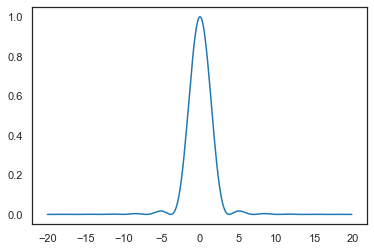

In [5]:
plt.plot(rho,y);

In [6]:
xx, yy = np.meshgrid(rho, y, sparse=True)

In [7]:
x = np.arange(-10, 10, 1e-2)
y = np.arange(-10, 10, 1e-2)
X, Y = np.meshgrid(x, y)
Rh = np.sqrt(X**2+Y**2)
z = (2*sp.special.j1(Rh)/(Rh))**2

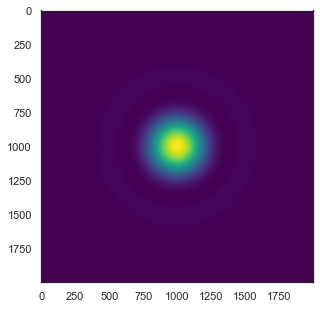

In [8]:
plt.figure(figsize = (5,5))
plt.imshow(z, cmap = 'viridis');
plt.savefig(figfile+'Airy-Disk.tif',dpi = 300)

### A Reasonable Airy Kernel

In [9]:
scale_true = 1000/140 #in nm/pixel
lam = 530 #in nm

In [10]:
kernel = anl.psf_airy(scale_true,lam)

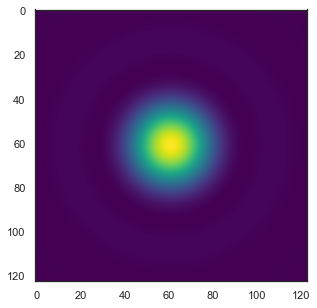

In [11]:
plt.figure(figsize = (5,5))
plt.imshow(kernel, cmap = 'viridis');
plt.savefig(figfile+'Airy-Kernel.tif',dpi = 300)

### 3.1 Convolving an image with an airy kernel

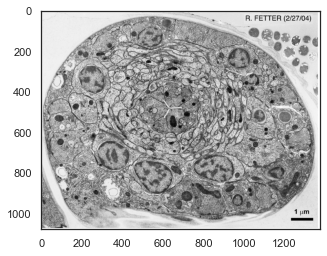

In [12]:
pic = np.array(img.imread('Images/fetter_Celegans_cellfig10.jpg')).astype('double')
plt.figure(figsize = (5,5))
plt.imshow(pic, cmap = 'gray')
plt.savefig(figfile+'unconvolved_fetter_Celegans_cellfig10.jpg',dpi = 300)

In [13]:
convolved = sp.ndimage.convolve(pic,kernel, mode = 'reflect')

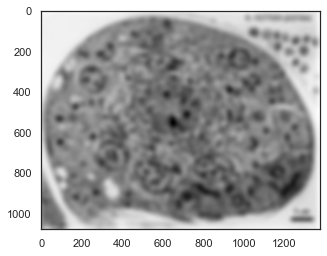

In [14]:
plt.figure(figsize = (5,5))
plt.imshow(convolved, cmap = 'gray')
plt.savefig(figfile+'airy_convolved_fetter_Celegans_cellfig10.jpg',dpi = 300)

## 2\. A Gaussian Approximation to Airy Function

In [15]:
convolved_gauss = ski.filters.gaussian(pic,anl.psf_sig(lam,scale_true))

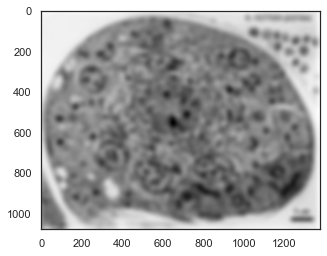

In [16]:
plt.figure(figsize = (5,5))
plt.imshow(convolved, cmap = 'gray')
plt.savefig(figfile+'airy_convolved_gauss-approx_fetter_Celegans_cellfig10.jpg',dpi = 300)

# Simulations -

## 3.2 Simulating Point Sources

In [17]:
scale_true = 5 #in nanometer/pixel
lam = 509 #in nanometer
NA = 1.3 #numerical aperture for light microscope

### 1\. Constructing True Image

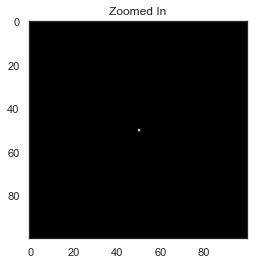

In [18]:
pic = np.zeros([1080,1080]); pic[300,700] = 1
plt.imshow(pic[250:350,650:750], cmap = 'gray'); plt.title('Zoomed In') 
plt.show()

### 2. Convolving 

2\.1 with Airy PSF

In [19]:
kernel = anl.psf_airy(scale_true,lam)

In [20]:
convolved = sp.ndimage.convolve(pic,kernel, mode = 'reflect')

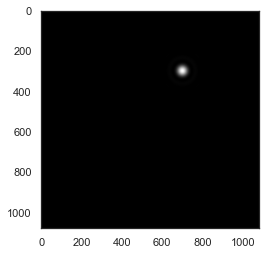

In [21]:
plt.imshow(convolved, cmap = 'gray');

2\.2 with Gaussian PSF

In [22]:
convolved = ski.filters.gaussian(pic,anl.psf_sig(lam,scale_true))

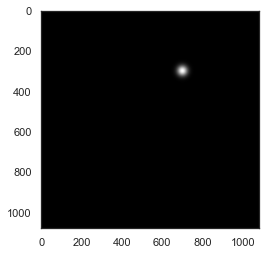

In [23]:
plt.imshow(convolved, cmap = 'gray')
plt.savefig(figfile+'ideal_convolved_point_obj.jpg',dpi = 300);

Note the similarity - the Gaussian approximation seems to do a reasonably good job.

### 3\. Pixelate the Image

In [24]:
ccd_scale = 100 #in nm/pixel

In [25]:
scaling_fac = ccd_scale/scale_true

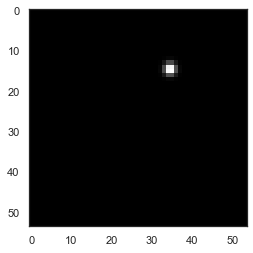

In [26]:
siz = ([np.round(ccd_scale/scale_true).astype('int')]*2); siz.extend([1]*(len(np.shape(convolved))-2))   
pixelated = ski.measure.block_reduce(convolved, block_size = tuple(siz), func = np.sum)
plt.imshow(pixelated, cmap = 'gray');

### 4\. Adding Poisson Noise - Intrinsic

In [27]:
SNr = 10 #signal to noise ratio

In [28]:
S = SNr**2

In [29]:
noisy_sgnl = np.random.poisson(pixelated*S/np.max(pixelated));

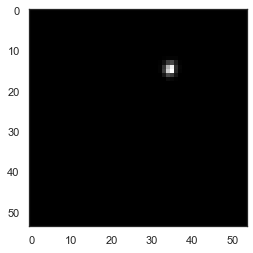

In [30]:
plt.imshow(noisy_sgnl, cmap = 'gray'); plt.show()

### 5\. Adding Poisson Noise - Extrinsic

In [31]:
bkg = 10

In [32]:
noisy_bkg = np.random.poisson(bkg*np.ones(np.shape(noisy_sgnl)))
final_img = noisy_bkg+noisy_sgnl

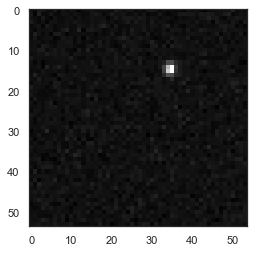

In [33]:
plt.imshow(final_img, cmap = 'gray')
plt.savefig(figfile+'simulated_point_obj.jpg',dpi = 300);

# Simulating an image given some _true image_ - 

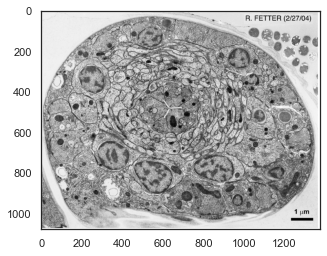

In [34]:
pic2 = np.array(img.imread('Images/fetter_Celegans_cellfig10.jpg')).astype('double')
plt.figure(figsize = (5,5))
plt.imshow(pic2, cmap = 'gray');

In [35]:
scale_true = 1000/140 #in nm/pixel
lam = 530 #in nm
ccd_scale = 100 #in nm/pixel
SNr = 10
bkg = 10

In [36]:
simulated = anl.simulator(pic2,scale_true,lam,ccd_scale,SNr,bkg,psf = 'gaussian')

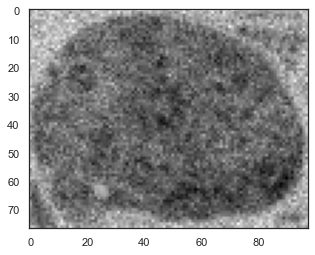

In [37]:
plt.figure(figsize = (5,5))
plt.imshow(simulated, cmap = 'gray');
plt.savefig(figfile+'simulated_fetter_Celegans_cellfig10.jpg',dpi = 300)

This is how we expect the image to look like in a light microscope - **convolved, pixelated and noisy**.

## 3.4 Simulating an image from scratch

### 3.4.1 Constructing a Cartoon Dendritic Arbour

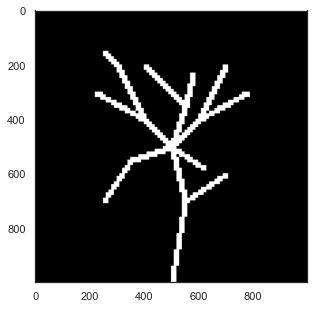

In [38]:
toon = np.zeros((100, 100), dtype=np.double)

#branch to junction 1
rr, cc, val = ski.draw.line_aa(99, 50, 70, 55); toon[rr, cc] = 255
#deviation from 1 - 2
rr, cc, val = ski.draw.line_aa(70, 55, 50, 50); toon[rr, cc] = 255
#deviation from 1 - end
rr, cc, val = ski.draw.line_aa(70, 55, 60, 70); toon[rr, cc] = 255
#deviation from 2 - 3
rr, cc, val = ski.draw.line_aa(50, 50, 35, 55); toon[rr, cc] = 255
#deviations from 2-4,2-5
rr, cc,val = ski.draw.line_aa(50, 50, 50-10, 50+10); toon[rr, cc] = 255
rr, cc,val = ski.draw.line_aa(50, 50, 50-10, 50-10); toon[rr, cc] = 255
#deviations from 4-end, 4-end
rr, cc, val = ski.draw.line_aa(50-10, 50+10, 50-10-10, 50+10+18); toon[rr, cc] = 255
rr, cc, val = ski.draw.line_aa(50-10, 50+10, 50-10-20, 50+10+10); toon[rr, cc] = 255
#deviations from 5-6, 5-end
rr, cc, val = ski.draw.line_aa(50-10, 50-10, 50-10-20, 50-10-10); toon[rr, cc] = 255
rr, cc, val = ski.draw.line_aa(50-10, 50-10, 50-10-10, 50-10-18); toon[rr, cc] = 255
#deviations from 3-end, 3-end
rr, cc, val = ski.draw.line_aa(35, 55, 35-12, 50+8); toon[rr, cc] = 255
rr, cc, val = ski.draw.line_aa(35, 55, 35-15, 50-10); toon[rr, cc] = 255
#deviations from 1-end, 1-7
rr, cc, val = ski.draw.line_aa(50, 50, 50+8, 50+12); toon[rr, cc] = 255
rr, cc, val = ski.draw.line_aa(50, 50, 50+5, 50-15); toon[rr, cc] = 255
#deviation from 6-end
rr, cc, val = ski.draw.line_aa(50-10-20, 50-10-10, 50-10-20-5, 50-10-15); toon[rr, cc] = 255
#deviation from 7-end
rr, cc, val = ski.draw.line_aa(50+5, 50-15, 50+20, 50-25); toon[rr, cc] = 255

toon = ski.transform.resize(toon,(1000,1000), order = 0)

plt.figure(figsize = (5,5))
plt.imshow(toon, cmap = 'gray')
plt.savefig(figfile+'idealized_dendrites.jpg',dpi = 300)

Specifying _true image_ and microscope properties

In [39]:
scale_true = 1000/150 #in nm/pixel
lam = 500 #in nm
ccd_scale = 100 #in nm/pixel
SNr = 10
bkg = 10

Running the `simulator` function on the true image

In [40]:
simulated = anl.simulator(toon,scale_true,lam,ccd_scale,SNr,bkg,psf = 'gaussian')

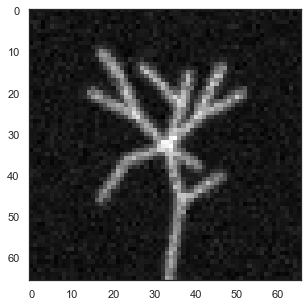

In [41]:
plt.figure(figsize = (5,5))
plt.imshow(simulated, cmap = 'gray')
plt.savefig(figfile+'simulated_dendrites.jpg',dpi = 300)

# Estimating CRLB - 

## 3.5 Calculating CRLB for a given point on the true image

Obtain the coordinates of the point for which you want to calculate CRLB on the true image.

In [42]:
r = 350; c = 550

Run the function `crlb` on the true image

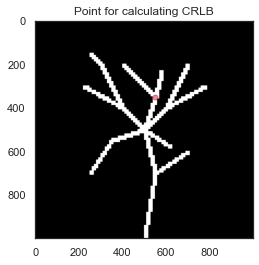

In [43]:
crlb, crlb_min = anl.crlb(toon,r,c,scale_true,lam,ccd_scale,SNr,bkg)

In [44]:
print('CRLB with pixelation and noise:', np.round(crlb,decimals = 2), ' nm')
print('CRLB without pixelation and noise:', np.round(crlb_min,decimals = 2), ' nm')

CRLB with pixelation and noise: 1.15  nm
CRLB without pixelation and noise: 0.52  nm


## 3.3 Calculating CRLB for a point source

In [45]:
scale_true = 5 #in nm/pixel
lam = 509 #in nm
ccd_scale = 100 #in nm/pixel
SNr = 10
bkg = 10

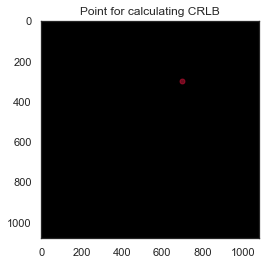

In [46]:
crlb, crlb_min = anl.crlb(pic,300,700,scale_true,lam,ccd_scale,SNr,bkg)

In [47]:
print('CRLB with pixelation and noise:', np.round(crlb,decimals = 2), ' nm')
print('CRLB without pixelation and noise:', np.round(crlb_min,decimals = 2), ' nm')

CRLB with pixelation and noise: 5.32  nm
CRLB without pixelation and noise: 3.34  nm
